In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
import re
import copy
import json

import datetime as dt
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

# Configure data

In [14]:
from src.parameters import Parameters
data_config = {
    'pat_id':Parameters(mode='uid', vector=None),
    'label':Parameters(mode='categorical', vector=None),
}

In [15]:
for v in viscat_rename:
    data_config[v]=Parameters(mode='numerical', vector='linear')

In [16]:
from src.ehr_utils import EHRFeature
from src.features import Featureset

features = Featureset('datasets', data_config)
features.load_ehr('dat.csv')
features.create_new_dataset(train_split=0.8, tag=1)

loading dataframe
converting lab values
updating config
creating features


# Load Data

In [17]:
from src.data_loaders import GroupDataset, GroupDataCollator

In [18]:
import torch

In [19]:
trainloader = torch.utils.data.DataLoader(
    GroupDataset(features.train_features), batch_size=100, shuffle=True, 
    collate_fn=GroupDataCollator(features.config, 'train')
)

testloader = torch.utils.data.DataLoader(
    GroupDataset(features.test_features), batch_size=100, shuffle=False, 
    collate_fn=GroupDataCollator(features.config, 'test')
)

In [20]:
def isNum(num):
    return num == num

maxLen=0
data_df=pd.read_csv('datasets/dat.csv')
for cat in tqdm(viscat_rename):
    for i in range(len(data_df)):
        v=eval(data_df[cat][i])
        if isNum(v) and len(v)>maxLen:
            maxLen=len(v)
print(maxLen)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.31it/s]

313


# Train model


In [21]:
for testN in range(1):
    from src.modules import MergeLayer, FlattenLayer, GroupLayer, GroupModel
    from src.modules import NonLinear, Linear, EmbeddingNonLinear
    from src.modules import GRU, EmbeddingGRU

    embedLayer={}
    for lab in viscat_rename:
        embedLayer[lab]=NonLinear(maxLen, 10, 4) 

    mergevar=tuple(viscat_rename)

    model = GroupModel({
        'embed':GroupLayer(embedLayer), 
        'proj':MergeLayer({
            'pred':mergevar,
        }), 

        'pred':GroupLayer({
            'pred':NonLinear(4*len(viscat_rename), 64, 2)
        })
    })

    model.eval()
    pass;
    ##########################################TRAINING#######################################
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim

    import datetime

    print_every = 2
    epochs = 50
    min_val_loss = np.Inf

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
    criterion = nn.CrossEntropyLoss()

    time_start = datetime.datetime.now()
    print('Start Time: %s'%time_start.strftime('%H:%M:%S'))

    for epoch in range(0, epochs):
        epoch_start = datetime.datetime.now()
        model.train();
        train_loss = 0.0
        test_loss = 0.0
        train_nbatches = 0
        test_nbatches = 0

        for inputs in trainloader:
            #NL for lab variables
            for varN in viscat_rename:
                inputs[varN]=inputs[varN].squeeze(dim=2)

            preds = model(inputs)

            loss = criterion(preds, inputs['label'].squeeze())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += float(loss)
            train_nbatches += 1

        model.eval();
        with torch.no_grad():
            for inputs in testloader:
                #NL for lab variables
                for varN in viscat_rename:
                    inputs[varN]=inputs[varN].squeeze(dim=2)
                preds = model(inputs)
                loss = criterion(preds, inputs['label'].squeeze())
                test_loss += float(loss)
                test_nbatches += 1

        train_loss/=train_nbatches
        test_loss/=test_nbatches
    ########################################################################################    
        #Early stopping
        if test_loss < min_val_loss:
            min_val_loss = test_loss
            es = 0
            torch.save(model.state_dict(), 'NoMaskMod'+str(testN)+'_g1.pt')
        else:
            es += 1
            print("Counter {} of 10".format(es))

        if es > 10:
            print("Early stopping with min_val_loss: ", min_val_loss, "and test_loss for this epoch: ", test_loss, "...")
            break
    #########################################################################################        

        if epoch%print_every == 0:
            print('Epoch {} || Train Loss: {:.3f} || Test Loss: {:.3f}'.format(
                str(epoch).zfill(3), train_loss, test_loss)
                 )
    # torch.save(model.state_dict(), 'NL_masking.pt')
    time_finish = datetime.datetime.now()
    print('End Time: %s'%time_finish.strftime('%H:%M:%S'))
    print('Completed in %s seconds'%(time_finish-time_start).total_seconds())
    pass;

    ####################################METRICS#######################################
    savedmodel = GroupModel({
        'embed':GroupLayer(embedLayer), 
        'proj':MergeLayer({
            'pred':mergevar,
        }), 

        'pred':GroupLayer({
            'pred':NonLinear(4*len(viscat_rename), 64, 2)
        })
    })
    savedmodel.load_state_dict(torch.load('NoMaskMod'+str(testN)+'_g1.pt'))

    from src.metrics import make_ROC_holdout, make_PR_holdout

    def get_preds_labels(model, data_loader):
        all_preds = []
        all_labels = []

        for data in data_loader:
            for varN in viscat_rename:
                data[varN]=data[varN].squeeze(dim=2)
            all_preds.append(model(data).cpu().detach())
            all_labels.append(data['label'].cpu().detach())

        return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

    preds, labels = get_preds_labels(savedmodel, trainloader)
    preds_test, labels_test = get_preds_labels(savedmodel, testloader)

    res=[preds, labels, preds_test, labels_test]
    torch.save(res, 'NOmask'+str(testN)+'_g1.pt')

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Start Time: 12:00:40


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 000 || Train Loss: 0.641 || Test Loss: 0.604


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 002 || Train Loss: 0.461 || Test Loss: 0.515


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 1 of 10
Epoch 004 || Train Loss: 0.407 || Test Loss: 0.526


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 2 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 3 of 10
Epoch 006 || Train Loss: 0.373 || Test Loss: 0.542


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 4 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 5 of 10
Epoch 008 || Train Loss: 0.351 || Test Loss: 0.559


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 6 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 7 of 10
Epoch 010 || Train Loss: 0.322 || Test Loss: 0.624


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 8 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 9 of 10
Epoch 012 || Train Loss: 0.311 || Test Loss: 0.618


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 10 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 11 of 10
Early stopping with min_val_loss:  0.49609410762786865 and test_loss for this epoch:  0.6368914076260158 ...
End Time: 12:01:08
Completed in 28.047723 seconds


<All keys matched successfully>

# Results

In [24]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.metrics import precision_score, balanced_accuracy_score, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [25]:
def make_ROC_holdout(output, labels,output2, labels2, names):
    lr_probs = F.softmax(output, dim=1)[:,1].detach().numpy()
    lr_probs2 = F.softmax(output2, dim=1)[:,1].detach().numpy()
    
    ns_probs = [0 for _ in range(len(labels))]
    # calculate scores
    ns_roc_auc = roc_auc_score(labels, ns_probs)
    lr_roc_auc = roc_auc_score(labels, lr_probs)
    lr_roc_auc2 = roc_auc_score(labels2, lr_probs2)
    print('Trainset ROC AUC=%.3f'%(lr_roc_auc))
    print('Testset ROC AUC=%.3f'%(lr_roc_auc2))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(labels, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(labels, lr_probs)
    lr_fpr2, lr_tpr2, _ = roc_curve(labels2, lr_probs2)
    # plot the roc curve for the model
    fig = plt.figure(figsize=(7.5,5))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Train set'+': ROC AUC=%.3f'%(lr_roc_auc))
    plt.plot(lr_fpr2, lr_tpr2, marker='.', label='Test set'+': ROC AUC=%.3f'%(lr_roc_auc2))
    # axis labels
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    # show the legend
    plt.ylim([-0.2,1.2])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=15)
    
def make_PR_holdout(output, labels,output2, labels2, names):
    lr_probs = F.softmax(output, dim=1)[:,1].detach().numpy()
    lr_probs2 = F.softmax(output2, dim=1)[:,1].detach().numpy()
    lr_precision, lr_recall, _ = precision_recall_curve(labels, lr_probs)
    lr_precision2, lr_recall2, thr = precision_recall_curve(labels2, lr_probs2)
    # calculate scores
    lr_auc = auc(lr_recall, lr_precision)
    lr_auc2 = auc(lr_recall2, lr_precision2)
    print('Trainset PR AUC=%.3f' % (lr_auc))
    print('Testset PR AUC=%.3f' % (lr_auc2))
    # plot the precision-recall curves
    fig = plt.figure(figsize=(7.5,5))
    no_skill = len(labels[labels==1]) / len(labels)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Train set'+': PR AUC=%.3f'%(lr_auc))
    plt.plot(lr_recall2, lr_precision2, marker='.', label='Test set'+': PR AUC=%.3f'%(lr_auc2))
    # axis labels
    plt.xlabel('Recall', fontsize=20)
    plt.ylabel('Precision', fontsize=20)
    plt.ylim([-0.2,1.2])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=15)


Trainset ROC AUC=0.884
Testset ROC AUC=0.811
Trainset PR AUC=0.802
Testset PR AUC=0.696


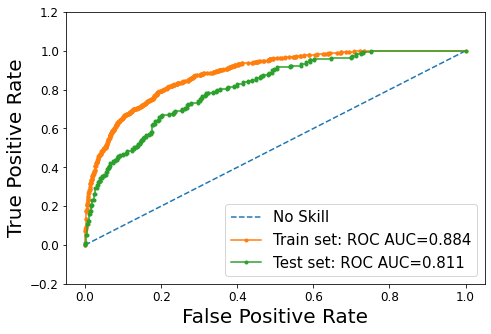

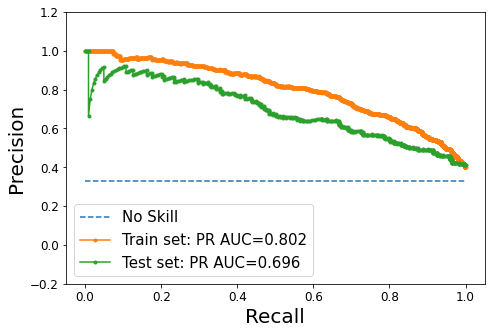

In [27]:
testN=0
res_anal=torch.load('Nomask'+str(testN)+'_g1.pt')

make_ROC_holdout(res_anal[0], res_anal[1], res_anal[2], res_anal[3], 'ROC')
make_PR_holdout(res_anal[0], res_anal[1], res_anal[2], res_anal[3], 'PR')